<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fff;">-----------------------------------
    
<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fa9200;">This NB Pulls Historical Stock Data from Yahoo Finance
    
<span style="font-family: Arial; font-weight:bold;font-size:2.1em;color:#fff;">-----------------------------------

# Import Packages

In [77]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, datetime
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.formula.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import yfinance as yf
from scipy.signal import argrelextrema
from collections import defaultdict

# Grab Data for Ticker

In [55]:
ticker = "CSX"
start_date = date(2000,1,1)
my_ticker = yf.Ticker(ticker)
df = my_ticker.history(period="180d", interval = "1h")
df = df.reset_index()
df['date'] = df.Datetime.dt.tz_localize(None)
df.columns = [x.lower() for x in df.columns]
#df.drop(['datetime'], axis=1, inplace=True)
df

,datetime,open,high,low,close,volume,dividends,stock splits,date
0,2023-06-21 09:30:00-04:00,32.770000,32.910000,32.540001,32.900002,1819397,0.0,0.0,2023-06-21 09:30:00
1,2023-06-21 10:30:00-04:00,32.900002,33.119999,32.845001,33.095001,890482,0.0,0.0,2023-06-21 10:30:00
2,2023-06-21 11:30:00-04:00,33.090000,33.209999,33.020000,33.200001,600622,0.0,0.0,2023-06-21 11:30:00
3,2023-06-21 12:30:00-04:00,33.195000,33.205002,33.082500,33.125000,606755,0.0,0.0,2023-06-21 12:30:00
4,2023-06-21 13:30:00-04:00,33.130001,33.200001,33.119999,33.169998,568655,0.0,0.0,2023-06-21 13:30:00
...,...,...,...,...,...,...,...,...,...
1249,2024-03-07 11:30:00-05:00,38.299999,38.330002,38.259998,38.259998,367918,0.0,0.0,2024-03-07 11:30:00
1250,2024-03-07 12:30:00-05:00,38.259998,38.345001,38.250000,38.288898,562591,0.0,0.0,2024-03-07 12:30:00
1251,2024-03-07 13:30:00-05:00,38.290001,38.299999,38.139999,38.139999,515454,0.0,0.0,2024-03-07 13:30:00
1252,2024-03-07 14:30:00-05:00,38.139999,38.160000,37.950001,37.959999,1268262,0.0,0.0,2024-03-07 14:30:00


# Plot Data

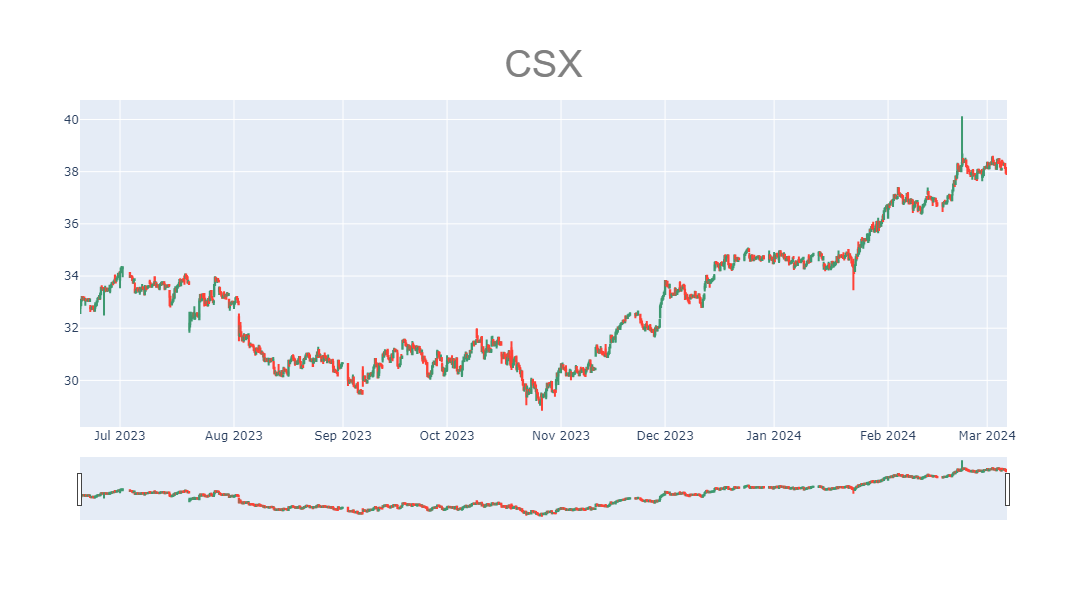

In [56]:
#df['date'] = df['date'].dt.strftime("%d-%m-%Y %H:%M:%S")
# build complete timepline from start date to end date
dt_all = pd.date_range(start=df['date'].iloc[0],end=df['date'].iloc[-1])
# retrieve the dates that ARE in the original datset
dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df['date'])]
# define dates with missing values
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38})
fig.show()

# Add SMAs

In [57]:
SMAs = [30,60,90]
for n in SMAs:
    df['SMA{}'.format(n)] = df['close'].rolling(window=n, center=False).mean()
df

,datetime,open,high,low,close,volume,dividends,stock splits,date,SMA30,SMA60,SMA90
0,2023-06-21 09:30:00-04:00,32.770000,32.910000,32.540001,32.900002,1819397,0.0,0.0,2023-06-21 09:30:00,NaN,NaN,NaN
1,2023-06-21 10:30:00-04:00,32.900002,33.119999,32.845001,33.095001,890482,0.0,0.0,2023-06-21 10:30:00,NaN,NaN,NaN
2,2023-06-21 11:30:00-04:00,33.090000,33.209999,33.020000,33.200001,600622,0.0,0.0,2023-06-21 11:30:00,NaN,NaN,NaN
3,2023-06-21 12:30:00-04:00,33.195000,33.205002,33.082500,33.125000,606755,0.0,0.0,2023-06-21 12:30:00,NaN,NaN,NaN
4,2023-06-21 13:30:00-04:00,33.130001,33.200001,33.119999,33.169998,568655,0.0,0.0,2023-06-21 13:30:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1249,2024-03-07 11:30:00-05:00,38.299999,38.330002,38.259998,38.259998,367918,0.0,0.0,2024-03-07 11:30:00,38.260883,38.151943,37.872087
1250,2024-03-07 12:30:00-05:00,38.259998,38.345001,38.250000,38.288898,562591,0.0,0.0,2024-03-07 12:30:00,38.274513,38.151258,37.887797
1251,2024-03-07 13:30:00-05:00,38.290001,38.299999,38.139999,38.139999,515454,0.0,0.0,2024-03-07 13:30:00,38.275513,38.146592,37.902852
1252,2024-03-07 14:30:00-05:00,38.139999,38.160000,37.950001,37.959999,1268262,0.0,0.0,2024-03-07 14:30:00,38.268180,38.139842,37.916519


# Plot with SMAs

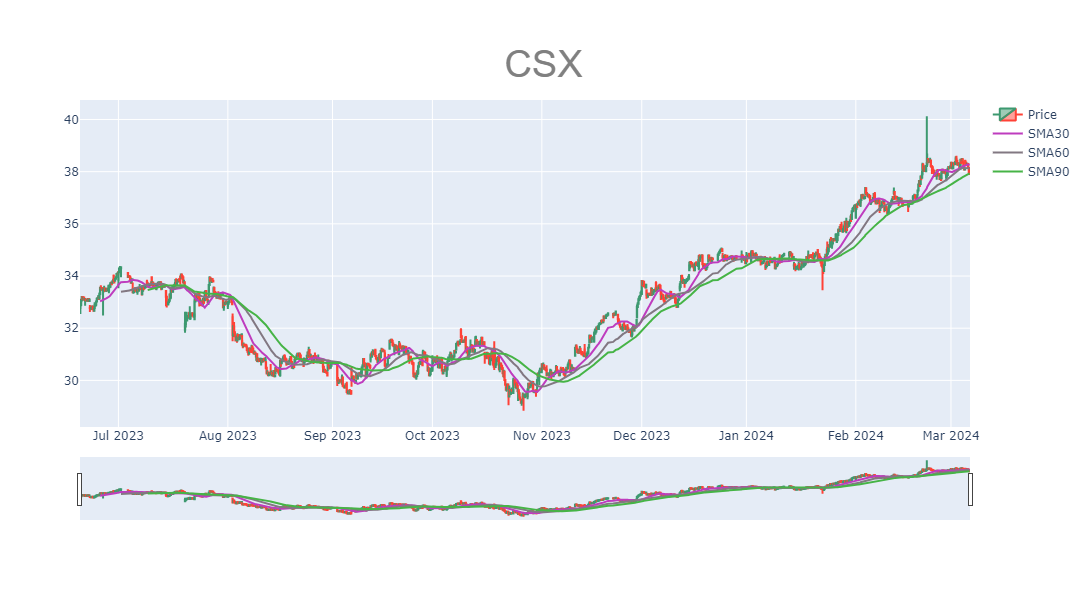

In [58]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
    
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38})
fig.show()

# Add Local Min/Max

In [81]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    #max_min.index.name = 'date'
    max_min = max_min.reset_index(drop=True)
    #max_min = max_min[~max_min.date.duplicated()]
    #p = prices.reset_index()   
    #max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    #max_min = max_min.set_index('day_num')['close']
    
    return max_min[['date','close']]

smoothing = 10
window = 15

minmax = get_max_min(df, smoothing, window)
minmax

,date,close
0,2023-06-23 14:30:00,32.665001
1,2023-06-28 15:30:00,33.630001
2,2023-07-03 13:00:00,34.340000
3,2023-07-03 13:00:00,34.340000
4,2023-07-07 15:30:00,33.299999
...,...,...
178,2024-03-01 09:30:00,37.849998
179,2024-03-05 09:30:00,38.500000
180,2024-03-05 09:30:00,38.500000
181,2024-03-05 09:30:00,38.500000


# Plot with Min/Max

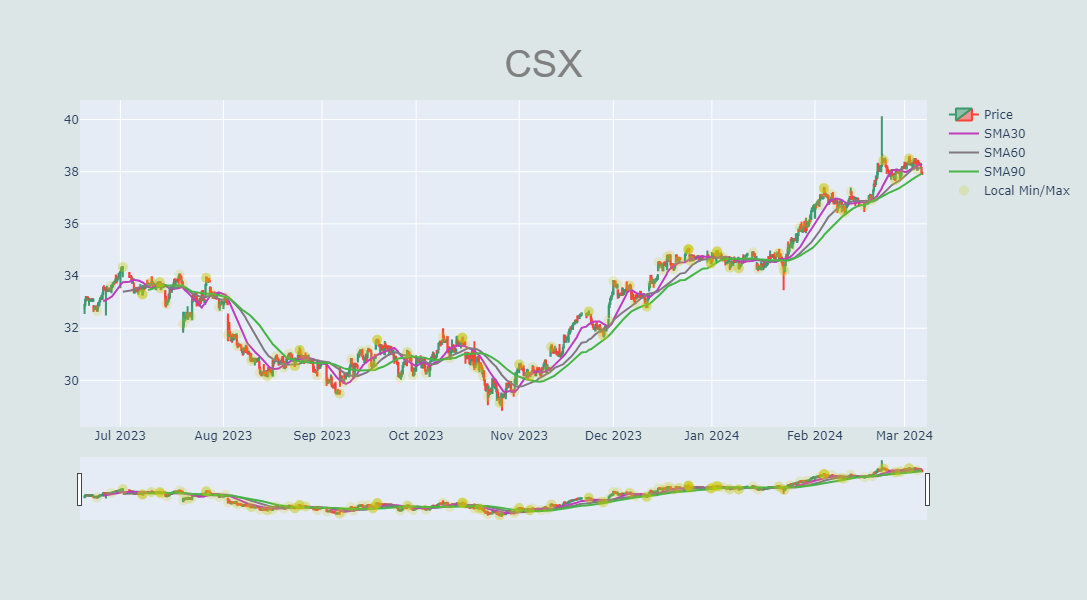

In [82]:
fig = go.Figure()
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'],
                name='Price')])
for n in SMAs:
    rgb = 'rgb({},{},{})'.format(250-n*2,n*2,250-n*2)
    fig.add_trace(go.Scatter(x=df['date'],
                y=df['SMA{}'.format(n)],
                mode='lines',
                name='SMA{}'.format(n),
                line=dict(color=rgb)))
fig.add_trace(go.Scatter(x=minmax['date'],
                y=minmax['close'],
                mode='markers',
                name='Local Min/Max',
                marker=dict(color='rgb(200,200,0)',
                            size=10,
                            opacity=0.2)
                        ))
    
fig.update_xaxes(
        rangeslider_visible=True,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            #dict(values=["2024-12-25", "2024-01-01","2024-01-15","2024-02-19"])  # hide holidays (Christmas and New Year's, etc)
        ]
    )
fig.update_layout(title={'text':ticker, 'xanchor':'center', 'yanchor':'top','x':0.5},
                height=600,
                title_font={"family":"arial","color":"gray","size":38},
                paper_bgcolor='rgb(220,230,230)'
                 )
fig.show()

# Add Head and Shoulders

In [90]:
def find_IHS(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]['close']
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<strong and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

invhs = find_IHS(minmax)
invhs

NameError: name 'strong' is not defined